In [1]:
import os
os.chdir("../")

In [2]:
import warnings
import numpy as np
import jax.numpy as jnp
from scipy import signal

import matplotlib.pyplot as plt
from matplotlib import rcParams as rc
configs = {
    'xtick.direction': 'in',
    'ytick.direction': 'in',
    # 'font.sans-serif': ['Microsoft YaHei', 'SimHei', 'Arial', 'Liberation Sans', 'sans-serif'],
    'font.sans-serif': ['Palatino Linotype', 'Microsoft YaHei', 'SimHei', 'Arial', 'Liberation Sans', 'sans-serif'],
    'axes.grid': True,
    'grid.alpha': 0.5,
    'grid.linestyle': '--',
    'mathtext.fontset': "cm",
    # 'mathtext.rm': "asana math",
    # 'mathtext.cal': "asana math",
    "font.size": 16,
    # 'axes.labelsize': 'large',
    # 'axes.labelpad': 8.0,
    # 'xtick.major.pad': 9.0,
}
rc.update(configs)


import matplotlib.font_manager
font_path = "/home/nanxi/.local/share/fonts/Palatino-Linotype-Regular.ttf"
if os.path.exists(font_path):
    matplotlib.font_manager.fontManager.addfont(font_path)
    prop = matplotlib.font_manager.FontProperties(fname=font_path)
    plt.rcParams['font.family'] = prop.get_name()
    print(f"Set font to {prop.get_name()}")

Set font to Palatino Linotype


In [3]:
def read_one_file(path, return_if_data_loss=False, need_fill=True):
    # Read one raw data file in one hour.
    if_data_loss = False
    with open(path, "r") as f:
        lines = f.readlines()[1:]
    data = []
    for line in lines:
        line = line.strip().split(",")[:2]
        line = list(map(float, line))
        data.append(line)
    data = np.array(data)
    if data.shape[0] < 3600:
        warnings.warn("Data length is less than 3600.")
        if need_fill:
            data = np.vstack([data, np.zeros((3600 - data.shape[0], 2))])
        if_data_loss = True
    if data.shape[0] > 3600:
        warnings.warn("Data length is more than 3600.")
        data = data[:3600]
    if return_if_data_loss:
        return data, if_data_loss
    else:
        return data

# data = read_one_file("./data/bridge_measurement.FS")
data = read_one_file("./data/FS040101_010000.FS")
data[:, 1] = np.deg2rad(data[:, 1])
ux = data[:, 0] * np.cos(data[:, 1])
uy = data[:, 0] * np.sin(data[:, 1])


# frequencies, psd, reference_psd = calculate_measured_psd(ux, uy, return_ref=True)

u_bar = np.sqrt(np.mean(ux)**2 + np.mean(uy)**2)
beta_bar = np.arctan2(np.mean(uy), np.mean(ux))
uu = ux * np.cos(beta_bar) + uy * np.sin(beta_bar) - u_bar

frequencies, psd = signal.welch(uu, fs=1.0, window='hann', 
                                scaling='density', nperseg=1024)
frequencies = frequencies[1:]
psd = psd[1:]

mean_wind_speed = np.sqrt(np.mean(ux)**2 + np.mean(uy)**2)
u10 = mean_wind_speed / (76/10)**0.12

z = 76
z0 = 0.01
H_ = 0.1
K = 0.4
zd = H_ - z0 / K
u_star = K * u_bar / np.log((z - zd) / z0)
f = frequencies * z / u_bar
reference_psd = 200 * f / (1 + 50 * f)**(5/3) * u_star**2 / frequencies

Fitted parameters: [16.86866528  9.0559074 ]


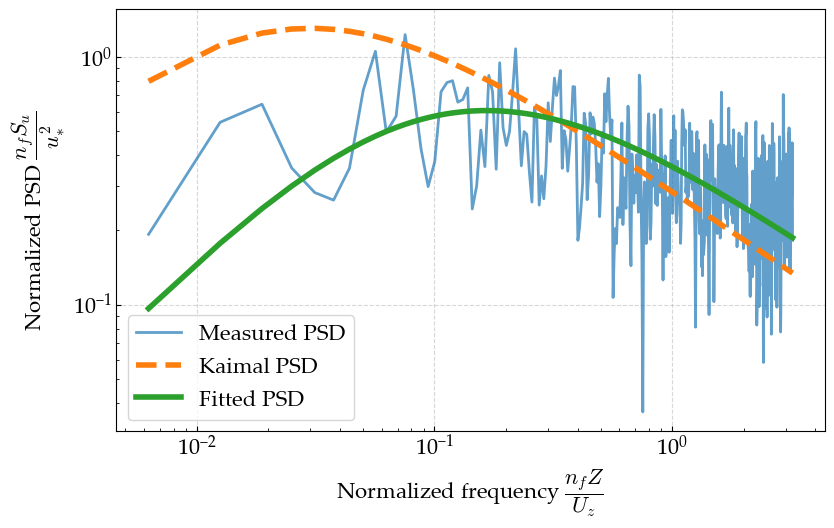

In [4]:
from scipy.optimize import curve_fit

normed_f = frequencies * z / u_bar
normed_psd = psd * frequencies / u_star**2

def func(f, a, b):
    return a * f / (1 + b * f)**(5/3)

popt, pcov = curve_fit(func, normed_f, normed_psd)
fitted_psd = func(normed_f, *popt)


fig, ax = plt.subplots(1, 1, figsize=(8, 5))
ax.loglog(frequencies*z/u_bar, psd*frequencies/u_star**2, label="Measured PSD", lw=2, alpha=0.7,)
ax.loglog(frequencies*z/u_bar, reference_psd*frequencies/u_star**2, label="Kaimal PSD", lw=4,  ls="--")
ax.loglog(normed_f, fitted_psd, label="Fitted PSD", lw=4, )
ax.legend(loc="lower left",)

fig.tight_layout()
x_notation = r"$\dfrac{n_fZ}{U_z}$"
y_notation = r"$\dfrac{n_fS_u}{u_{*}^2}$"
ax.set_xlabel("Normalized frequency " + x_notation,)
ax.set_ylabel("Normalized PSD " + y_notation,)
fig.savefig("./img/bridge_wind_fitted_psd.png", dpi=300, bbox_inches="tight")
fig.savefig("./img/bridge_wind_fitted_psd.pdf", bbox_inches="tight")

print("Fitted parameters:", popt)
a, b = popt

In [5]:
u_bar

np.float64(11.83342597999078)

In [6]:
from stochastic_wind_simulate.jax_backend.psd import WindSpectrumNonDimensional

class CustomSpectrum(WindSpectrumNonDimensional):

    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def calculate_power_spectrum_u(self, n, u_star, f):
        """Calculate along-wind fluctuating wind power spectral density S_u(n)."""
        return (u_star**2 / n) * (a * f / ((1 + b * f) ** (5 / 3)))
    
reference_psd = (u_star**2 / frequencies) * (a * normed_f / ((1 + b * normed_f) ** (5 / 3)))

In [7]:

from stochastic_wind_simulate import get_simulator, get_visualizer
simulator = get_simulator(backend="jax", key=41, spectrum_type=CustomSpectrum)
fs = 1.0
T = int(data.shape[0]/fs)
w_up = fs/2
N = int(T * w_up)
alpha_0 = 0.12
z0 = 0.01
H_ = 0.1
K = 0.4
simulator.update_parameters(
    H_bar=H_,
    z_0=z0,
    T=T,
    N=N,
    U_d=u10,
    alpha_0=alpha_0,
    w_up=w_up,
)
n = 101
Z = 76
position = np.zeros((n, 3))
position[:, 2] = Z
position[:, 1] = 5
pos_x = np.linspace(0, 544, 51)
neg_x = -1 * pos_x[::-1][:-1]
x = np.hstack([neg_x, pos_x])
position[:, 0] = x
wind_speeds = np.ones_like(position[:, 0]) * mean_wind_speed
samples, frequencies_sim = simulator.simulate_wind(
    position, wind_speeds, component="u"
)
frequencies_sim, psd_sim = signal.welch(samples[50], fs=1/simulator.params["dt"], window='hamming', 
                                   scaling='density', nperseg=1024)

In [8]:
simulator.params

{'K': 0.4,
 'H_bar': 0.1,
 'z_0': 0.01,
 'alpha_0': 0.12,
 'C_x': 16.0,
 'C_y': 6.0,
 'C_z': 10.0,
 'w_up': 0.5,
 'N': 1800,
 'z_max': 450.0,
 'U_d': np.float64(9.277113446634836),
 'M': 3600,
 'T': 3600.0,
 'dt': 1.0,
 'dw': 0.0002777777777777778,
 'z_d': 0.07500000000000001,
 'backend': 'jax'}

In [9]:
# visualizer = get_visualizer(backend="jax", key=42, simulator=simulator)
# visualizer.plot_psd(samples, position[:, -1], show_num=6, show=True, component="u")

[Text(0.5, 0, 'Frequency (Hz)'),
 Text(0, 0.5, 'Power Spectral Density (m$^2$/s)')]

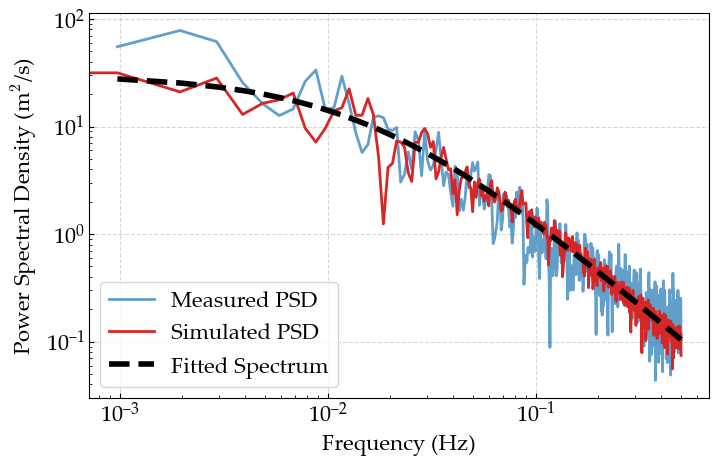

In [10]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5))
ax.loglog(frequencies, psd, label="Measured PSD", color="C0", lw=2, alpha=0.7,)
ax.loglog(frequencies_sim, psd_sim, label="Simulated PSD", color="C3", linestyle="solid", lw=2)
ax.loglog(frequencies, reference_psd, label="Fitted Spectrum", color="black", linestyle="--", lw=4)
ax.legend(loc="lower left")
ax.set(xlabel="Frequency (Hz)", ylabel="Power Spectral Density (m$^2$/s)")
# fig.savefig("./img/bridge_wind_spectrum.pdf", bbox_inches="tight")
# fig.savefig("./img/bridge_wind_spectrum.png", bbox_inches="tight", dpi=300)

In [11]:
psd_sim.shape

(513,)

[Text(0.5, 0, 'Normalized frequency $\\dfrac{n_fZ}{U_z}$'),
 Text(0, 0.5, 'Normalized PSD $\\dfrac{n_fS_u}{u_{*}^2}$')]

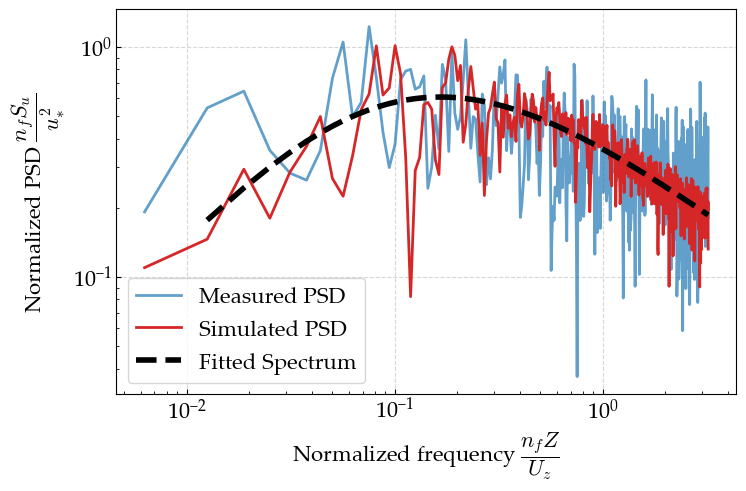

In [12]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5))
ax.loglog(frequencies*z/u_bar, psd*frequencies/u_star**2, label="Measured PSD", color="C0", lw=2, alpha=0.7,)
ax.loglog(frequencies_sim[1:]*z/u_bar, psd_sim[1:]*frequencies_sim[1:]/u_star**2, label="Simulated PSD", color="C3", linestyle="solid", lw=2)
ax.loglog(frequencies[1:]*z/u_bar, reference_psd[1:]*frequencies[1:]/u_star**2, label="Fitted Spectrum", color="black", linestyle="--", lw=4)
ax.legend()
x_notation = r"$\dfrac{n_fZ}{U_z}$"
y_notation = r"$\dfrac{n_fS_u}{u_{*}^2}$"

ax.set(xlabel="Normalized frequency " + x_notation,
         ylabel="Normalized PSD " + y_notation)
# fig.savefig("./img/bridge_wind_spectrum_norm.pdf", bbox_inches="tight")
# fig.savefig("./img/bridge_wind_spectrum_norm.png", bbox_inches="tight", dpi=300)

[Text(0.5, 0, 'Time (s)'), Text(0, 0.5, 'Wind Speed (m/s)'), (0.0, 3600.0)]

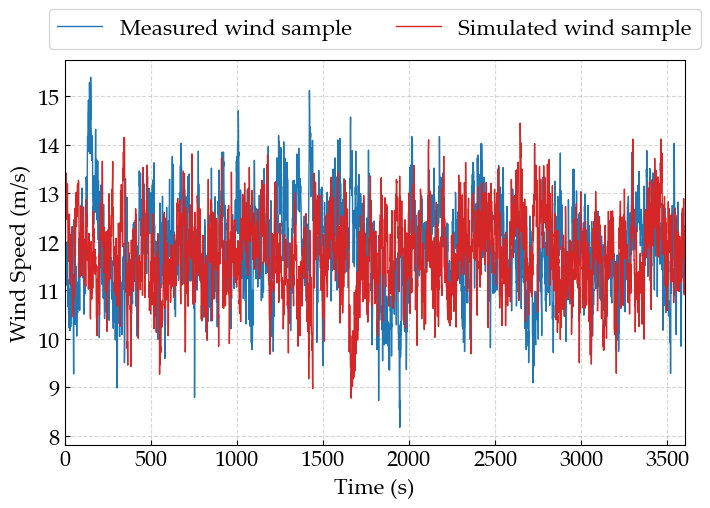

In [13]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5))
ax.plot(data[:, 0], label="Measured wind sample", color="C0", lw=1)
ax.plot(samples[50]+wind_speeds[50], label="Simulated wind sample", color="C3", 
        linestyle="solid", lw=1,)
ax.legend(ncol=2, loc="lower center", bbox_to_anchor=(0.5, 1.0))
ax.set(xlabel="Time (s)", ylabel="Wind Speed (m/s)", xlim=(0, 3600))
# fig.savefig("./img/bridge_wind_timehistory.pdf", bbox_inches="tight")
# fig.savefig("./img/bridge_wind_timehistory.png", bbox_inches="tight", dpi=300)